In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os

# Week 1: Pulsars and Image Stacking

After a supernova, a star collapses into a smaller but dense neutron star. By conservation of angular momentum, it’s rotation speed increases after collapse. Also, like the Earth, stars have magnetic fields. And when a star collapses, it takes the fields with it. So, neutron stars would have incredibly intense magnetic fields. Charged particles in the super-hot plasma surrounding a neutron star, would get funneled towards the star's magnetic poles and shot out into space as two intense beams. Putting these two ideas together, a neutron star becomes a bit like a lighthouse, rapidly spinning in space, flashing its energy beams across the universe.

Typical MWA(Murchison Widefield Array) Image:


![Image](https://imgur.com/OTQJxjQ.png)

In radio astronomy, flux density is measured in units of Janskys:

$
1 Jy = 10^{-26} W m^{-2} Hz ^{-1}
$

![Image](https://imgur.com/024TFNI.png)

Some people like to display their images in false color, but remember, radio frequencies don't have color. These color maps are just used to accentuate different aspects of the intensity scale.


### Detection:
Typically, a signal is classified as the destection if the flux density is more than 5 standard deviations higher than the noise in the local region.


When we don't detect something, it could be for a whole range of reasons. It could be that the pulsar is too far away, it could be the intrinsic emission isn't strong at these frequencies, or it could be that the emission is intermittent and switched off.

Stacking allows us to measure the statistical properties of a population we can't detect.Stacking works because the noise in a radio image is roughly random, with a Gaussian distribution centered on zero. When you add regions of an image that just have noise, the random numbers cancel out. But when you add regions of an image in which there are signals, the signals add together, increasing what we call the signal to noise ratio.


![Img](https://imgur.com/oN7ZZet.jpg)

### Astropy and FITS:
One of the most widely used formats for astronomical images is the Flexible Image Transport System. In a FITS file, the image is stored in a numerical array, which we can load into a NumPy array. FITS files also have headers which store metadata about the image.
To improve the robustness of this method to outliers, we implement a median stack instead of using the mean. Now, the above methods involved holding all the images in memory at once. This is a bad idea if there are a lot of images.

We can instead calculate a running mean, i.e, calculate the mean cumulatively, while holding only one image in memory at a time. This can easily be done for the mean, but not for the median. Instead, we can use an approximation for the median, called the Bin-Approx Algorithm.


### Bin-Approx Algorithm:
The Bin-Approx Algorithm saves even more time and space by only looking for the median within one standard deviation of the mean (see the link if you’d like to know why that works).

The full algorithm for a set of N data points is as follows:

    1) Calculate their mean and standard deviation, μ and σ.
    2) Set the bounds: minval =  μ − σ and maxval =  μ + σ. Any value >= maxval is ignored
    3) Set the bin width: width =  2σ/B
    4) Make an ignore bin for counting value < minval
    5) Make B bins for counting values in minval and maxval, e.g. the first bin is minval <= value < minval + width
    6) Count the number of values that fall into each bin
    7) Sum these counts until total >= (N + 1)/2. Remember to start from the ignore bin.
    8) Return the midpoint of the bin whose cumulative sum exceeds (N + 1)/2

![Img](https://imgur.com/EgOmNbr.jpg)

In [2]:
# Write your load_fits function here.
def load_fits(name):
    hdulist = fits.open(name)
    data = hdulist[0].data
    #Return max index (2d index)
    #data.argmax() flattens the array and gives index of max value
    #We unravel it using unravel_index()
    return np.unravel_index(data.argmax(), data.shape)


def plot_fits_image(data):
    # Plot the 2D image data
    plt.imshow(data.T, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.show()

In [3]:
def running_stats(filenames):
    '''Calculates the running mean and stdev for a list of FITS files using Welford's method.'''
    n = 0
    for filename in filenames:
        hdulist = fits.open(filename)
        data = hdulist[0].data
        if n == 0:
            mean = np.zeros_like(data)
        s = np.zeros_like(data)
        n += 1
        delta = data - mean
        mean += delta/n
        s += delta*(data - mean)
        hdulist.close()
    s /= n - 1
    np.sqrt(s, s)
    if n < 2:
        return mean, None
    else:
        return mean, s

In [4]:
def bin_approx_median(filenames, B):
    N = len(filenames)
    mid = (N + 1)/2
    mean_arr ,std_arr = running_stats(filenames)
    x,y = mean_arr.shape        #To create new arrays, we want shape of image: width x and height y
    ignore_bin = np.zeros((x,y))    #Ignore bin is a 2D array identical to image shape, i.e x*y ignore_bins for x*y pixels
    bin_arr = np.zeros((x,y,B))         #Apart from ignore bin, each of the x*y pixels will have B bins thus shape (x,y,B)
    bin_width_arr = 2*std_arr/B
    for name in filenames:
        hdulist = fits.open(name)
        data = hdulist[0].data
        for i in range(x):
            for j in range(y):
                pixel_val = data[i,j]
                mean = mean_arr[i,j]
                std = std_arr[i,j]
                min_val = mean - std
                max_val = mean + std
                bin_width = 2*std/B
                
                if pixel_val < min_val:
                    ignore_bin[i,j] +=1
                elif pixel_val >= max_val:
                    pass
                else:
                    bin_choice = int((pixel_val - (mean - std))/bin_width)
                    bin_arr[i,j,bin_choice]+=1
    #We now have bin_arr
    median_arr = np.zeros((x,y))
    for i in range(x):
        for j in range(y):
            count = ignore_bin[i, j]
            for b, bincount in enumerate(bin_arr[i, j]):
                count += bincount
                if count >= mid:
                    # Stop when the cumulative count exceeds the midpoint
                    break
            median_arr[i, j] = mean_arr[i, j] - std_arr[i, j] + bin_width_arr[i, j]*(b + 0.5)    
    return median_arr

In [5]:
median = bin_approx_median([os.path.join("Week 1",'image{}.fits').format(str(i)) for i in range(11)], 4)

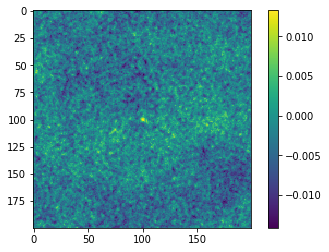

In [6]:
plot_fits_image(median)

### Results:

We wanted to find how many pulsars were emitting at the radio frequencies detected by the MWA. Initially, our investigation showed that most were not detected. But we decided to use mean (and then later median) stacking to improve our signal to noise ratio and make a statistical detection of the invisible population. Median stacking for a large population took a lot of computation and thus we used the Bin-Approx algorithm to save computational time. After stacking, we were able to successfully detect the pulsar.

### Further Reading:

    1) Introduction to Pulsars (from CSIRO, beginner) Hobbs, M. (n.d.). An introduction to pulsars. Retrieved February 14, 2017, from http://www.atnf.csiro.au/outreach/education/everyone/pulsars/index.html

    2) Pulsar Properties (from NRAO, advanced) National Radio Astronomy Observatory. (2010). Pulsar Properties. Retrieved February 14, 2017, from http://www.cv.nrao.edu/course/astr534/Pulsars.html

    3) Image stacking to detect quasars White, R. L., Helfand, D. J., Becker, R. H., Glikman, E., & de Vries, W. (2007). Signals from the noise: Image stacking for quasars in the FIRST survey. The Astrophysical Journal, 654(1), 99-114. doi:10.1086/507700

    4) Stacking of radio images to study faint, high-redshift galaxies
    Lindroos, L., Knudsen, K., Vlemmings, W., Conway, J., Marti-Vidal, I. (2015). Stacking of large interferometric data sets in the image- and uv-domain - a comparative study. Monthly Notices of the Royal Astronomical Society, 446(4), 3502-3515. doi:10.1093/mnras/stu2344

    5) Radio visibility stacking to search for Type 1a supernova Hancock, P. P., Gaensler, B. M., & Murphy, T. (2011). Visibility stacking in the quest for type ia supernova radio emission. Astrophysical Journal Letters, 735(2) doi:10.1088/2041-8205/735/2/L35

    6) Fast Computation of the Median by Successive Binning
    http://www.stat.cmu.edu/~ryantibs/papers/median.pdf

***

# Week 2: Cross Matching


Now say you've carried out two surveys: one in radio bands and another in optical bands. To combine this information together, we need to match the objects in the radio survey with the objects in the optical survey.

To do this, we create a catalogue of objects from each survey, and then do a positional cross-match.

The process of positional cross-matching seems pretty straightforward, but it doesn't scale well with the size of the catalog.

When we create a catalog from survey images, we start by extracting a list of sources, galaxies and stars, using source-finding software, say sExtractor. This software runs through the pixels in an image and find peaks that are statistically significant.

Then, they group the surrounding pixels and fit a function (called beam/point spread function), which results in a list of objects, each of which has a position, an angular size and an intensity measurement.

Once we have our catalogues, cross-matching involves searching the second catalogue to find a counterpart for each object in the first catalogue. To do this, we usually search within a given radius, based on the uncertainties in the position.

The algorithm can be described as:
![Img](https://imgur.com/R3M4Lp9.jpg)

The problem with this, however, is that it doesn't scale well since it has $\mathcal{O}(n^2)$ time complexity.

In this activity you'll cross-match two catalogues: one from a radio survey, the [AT20G Bright Source Sample (BSS) catalogue](http://cdsarc.u-strasbg.fr/viz-bin/Cat?J/MNRAS/384/775) (radio spectrum) and one from an optical survey, the [SuperCOSMOS all-sky galaxy catalogue](http://ssa.roe.ac.uk/allSky) (visible spectrum).

We've chosen one small catalogue (BSS has only 320 objects) and one large one (SuperCOSMOS has about 240 million) to demonstrate the issues you can encounter when implementing cross-matching algorithms.

Right ascension is often given in hours-minutes-seconds (HMS) notation, because it was convenient to calculate when a star would appear over the horizon. A full circle in HMS notation is 24 hours, which means 1 hour in HMS notation is equal to 15 degrees. Each hour is split into 60 minutes and each minute into 60 seconds.

Declination, on the other hand, is traditionally recorded in degrees-minutes-seconds (DMS) notation. A full circle is 360 degrees, each degree has 60 arcminutes and each arcminute has 60 arcseconds.

#### Note: arcminutes and minutes are different!
The arcminutes and arcseconds in DMS are not the same as the minutes and seconds in HMS! A minute in HMS is equal to 15 arcminutes in DMS and a second is equal to 15 arcseconds.



In [7]:
def hms2dec(h,m,s):
    #Function to convert HMS to decimal degress
    tot_hrs = (h + m/60 + s/3600)
    deg = 15*tot_hrs #(1 hour in HMS notation is equal to 15 degrees)
    return deg

def dms2dec(d,m,s):
    #Function to convert DMS to decimal degress
    if d < 0:
        sign = -1
    else:
        sign = 1
    deg = sign*(abs(d) + m/60 + s/3600)
    return deg


To crossmatch two catalogues we need to compare the angular distance between objects on the celestial sphere. We'll calculate angular distance using the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula), which is good at avoiding floating point errors when the two points are close together.

The formula is as follows:

$
d = 2\:\arcsin \sqrt{\sin^2\frac{\mid{\delta_1 - \delta_2}\mid}{2}+ \cos{\delta_1} \cos{\delta_2} \sin^2\frac{\mid{\alpha_1 - \alpha_2}\mid}{2}}
$

In [8]:
def angular_dist(ra1, dec1, ra2, dec2):
    '''
    Function takes arguments in decimal degrees and return the distance in decimal degrees.
    '''
    # Convert to radians
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    ra2 = np.radians(ra2)
    dec2 = np.radians(dec2)

    a = np.sin(np.abs(dec1 - dec2)/2)**2
    b = np.cos(dec1)*np.cos(dec2)*np.sin(np.abs(ra1 - ra2)/2)**2

    angle = 2*np.arcsin(np.sqrt(a + b))
    # Convert back to degrees
    return np.degrees(angle)

### Data
Every astronomy catalogue tends to have its own unique format so we'll need to look at how to do this with each one individually.

We'll look at the AT20G bright source sample survey first. The raw data we'll be using is the file table2.dat from [this](http://cdsarc.u-strasbg.fr/viz-bin/Cat?J/MNRAS/384/775) page in the VizieR archives, but we'll use the filename bss.dat from now on.

Every catalogue in VizieR has a detailed README file that gives you the exact format of each table in the catalogue.

The catalogue is organised in fixed-width columns, with the format of the columns being:

1: Object catalogue ID number (sometimes with an asterisk)

2-4: Right ascension in HMS notation

5-7: Declination in DMS notation

8-: Other information, including spectral intensities

We only need coordinates for crossmatching. 

The SuperCOSMOS all-sky catalogue is a catalogue of galaxies generated from several visible light surveys.

The original data is available on [this](http://ssa.roe.ac.uk/allSky) page in a package called SCOS_XSC_mCl1_B21.5_R20_noStepWedges.csv.gz. Because this catalogue is so large, we've cut it down for these activities. The cut down version of the file will be named super.csv.

Aside from the first row, which contains column labels, the format is:

1: Right ascension in decimal degrees

2: Declination in decimal degrees

3: Other data, including magnitude and apparent shape



In [9]:
'''
Each function returns a list of tuples containing the object's ID (an integer) and the coordinates in degrees.
The object ID is the row of the object in the catalogue, starting at 1.
'''
def import_bss():
    arr = np.loadtxt(os.path.join("Week 2",'bss.dat'), usecols=range(1, 7))
    ls=[]
    for i,row in enumerate(arr):
        h=row[0]
        m1=row[1]
        s1=row[2]
        ra = hms2dec(h,m1,s1)
        d=row[3]
        m2=row[4]
        s2=row[5]
        dec = dms2dec(d,m2,s2)
        tup = i+1, ra, dec
        ls.append(tup)
    return ls

def import_super():
    arr = np.loadtxt(os.path.join("Week 2",'super.csv'), delimiter=',', skiprows=1, usecols=[0, 1])
    ls=[]
    for i,row in enumerate(arr):
        ra = row[0]
        dec = row[1]
        tup = i+1, ra, dec
        ls.append(tup)
    return ls

In [10]:
def find_closest(cat,ra,decl):
    min_dist = np.inf
    min_obj = None
    for elem in cat:
        obj_id, ra2, decl2 = elem
        dist = angular_dist(ra,decl,ra2,decl2)
        if dist < min_dist:
            min_obj=obj_id
            min_dist = dist
    return min_obj,min_dist

In [11]:
def crossmatch(cat1,cat2,max_dist):
    matches=[]
    no_matches = []
    for elem1 in cat1:
        obj_id1,ra1,decl1 = elem1
        min_dist = np.inf
        min_obj2 = None
        for elem2 in cat2:
            obj_id2,ra2,decl2 = elem2
            dist = angular_dist(ra1,decl1,ra2,decl2)
            if dist<min_dist:
                min_obj2=obj_id2
                min_dist = dist
        #Check once loop has finished
        if min_dist<max_dist:
            append_elem = obj_id1,min_obj2,min_dist
            matches.append(append_elem)
        else:
            no_matches.append(obj_id1)
            #Only return obj_id of element from 2nd catalogue
    return matches, no_matches

In [12]:
if __name__ == '__main__':
    bss_cat = import_bss()
    super_cat = import_super()

    # First example in the question
    max_dist = 40/3600
    matches, no_matches = crossmatch(bss_cat, super_cat, max_dist)
    print(matches[:3])
    print(no_matches[:3])
    print(len(no_matches))

    # Second example in the question
    max_dist = 5/3600
    matches, no_matches = crossmatch(bss_cat, super_cat, max_dist)
    print(matches[:3])
    print(no_matches[:3])
    print(len(no_matches))

[(1, 2, 0.00010988610938710059), (2, 4, 0.0007649845967242494), (3, 5, 0.00020863352870707666)]
[5, 6, 11]
151
[(1, 2, 0.00010988610938710059), (2, 4, 0.0007649845967242494), (3, 5, 0.00020863352870707666)]
[5, 6, 11]
197


As we saw earlier, this has time complexity of $\mathcal{O}(n^2)$ if both catalogues have size n, or more generally $\mathcal{O}(n m)$ if size of each catalogue is n and m, respectively.

![Img](https://imgur.com/ksBBl2p.jpg)


Now, if the galaxies in our second catalog were sorted in order of their Declination, then as soon as we reach a point that's further away from that position, we could break out of our loop. There's no need to cross match our galaxy with anything further away than this.

This will roughly improve our computation speed by a factor of 2.

For 2 catalogues with a million sources, that would reduce the computation time from 24 days to 12 days. But, we still haven't actually improved the worst case time complexity.

Often, we can implement some practical improvements as above, without changing the formal time complexity (Big Oh). What we've done is reduce the constant factors in our time complexy equation. 

Thus, we can speed up a program by:
![TimeComplexityImage](https://imgur.com/7MxtnOM.jpg)

### k-d Trees

If we use Astropy's inbuilt crossmatching feature, it took only 25 seconds as compared to 12/24 days before. This is done with the help of a data structure called k-d trees, where k is the number of dimensions (2 in this case - ra and decl).

To construct a k-d tree, you have to recursively partition the space at the median point each time.

Once the tree is constructed, it can be used for fast nearest neighbor searching.

The great thing about k-d trees is that the nearest neighbor can be found without having to consider most of the nodes in the tree. For large datasets, the savings are enormous.



Creating a k-d tree from an astronomy catalogue works like this:

    1) Find the object with the median ra (x coord), split the catalogue into objects left and right partitions of this
    2) Find the objects with the median decl (y coord) in each partition, split the partitions into smaller partitions of objects down and up of these
    3) Find the objects with median ra (x coord) in each of the partitions, split the partitions into smaller partitions of objects left and right of these
    4) Repeat 2-3 until each partition only has one object in it

This creates a binary tree where each object used to split a partition (a node) links to the two objects that then split the partitions it has created (its children).


Once you've made a k-d tree out of a catalogue, finding a match to an object then works like this:

    1) Calculate the distance from the object to highest level node (the root node), then go to the child node closest (in right ascension) to the object
    2) Calculate the distance from the object to this child, then go to the child node closest (in declination) to the object
    3) Calculate the distance from the object to this child, then go to the child node closest (in right ascension) to the object
    4) Repeat 2-3 until you reach a child node with no further children (a leaf node)
    5) Find the shortest distance of all distances calculated, this corresponds to the closest object


#### Some notes:

    1) A database would be a better way of storing the data. This would avoid using many valuable CPU cycles reading in your input catalog each time.
    2) To evaluate whether the matches are just chance coincidencesor they have a real, physical association, we could measure the redshift for both objects. If the redshifts are similar, then it's much more likely they're physically associated.
    3) A statistical analysis could be carried out to calculate the likelihood of a chance coincidence given the spatial density of objects in the two surveys.

We can improve our original crossmatch by:

    1) Using numpy functions wherever possible, since they're written in C and Fortran.
    2) Converting all of cat1,cat2 to radians instead of in the loop when calculating distance.

In [13]:
# TO BE FILLED
# https://groklearning.com/learn/data-driven-astro/module-4/2/
# https://groklearning.com/learn/data-driven-astro/module-4/4/

Another optimisation:

    3) Ignore objects in the second catalogue with a declination far from the first catalogue object currently being matched, by: looping through the second catalogue objects in order of declination, rather than ID; and then breaking when the declination of the second catalogue object exceeds the target declination by the maximum radius.


In [14]:
# TO BE FILLED
# https://groklearning.com/learn/data-driven-astro/module-4/6/

We can improve on the previous optimisation further: 

    4) Stop the search once it gets past declination of the object to be matched AND (new:) start the search as close as possible to the object. That is: Sort the second catalogue objects by order of declination; then Start the search loop at the first second catalogue object with declination greater than δ − r ; and Finish the search loop at the last second catalogue object with declination less than δ + r.

If a list is sorted, it can be much faster to find the index of some element using a binary search, rather than doing comparisons on every element in the list.



In [15]:
# TO BE FILLED
# https://groklearning.com/learn/data-driven-astro/module-4/10/

Finally, let us use Astropy:

The SkyCoord objects are general purpose sky catalogue storage and manipulation objects in Astropy. They take anything that looks like an array of coordinates as long as you specify the units (here we specify degrees with u.degree) and a reference frame (ICRS is essentially the same as equatorial coordinates. The outputs, closest_id and closest_dists give the matching object's row index in sky_cat2 and the distance to it. closest_dists is the angular distance while closest_dists3d is the 3D distance which we're not concerned with here.

In [16]:
#ASTROPY CROSSMATCHING EXAMPLE
from astropy.coordinates import SkyCoord
from astropy import units as u
coords1 = [[270, -30], [185, 15]]
coords2 = [[185, 20], [280, -30]]
sky_cat1 = SkyCoord(coords1*u.degree, frame='icrs')
sky_cat2 = SkyCoord(coords2*u.degree, frame='icrs')
closest_ids, closest_dists, closest_dists3d = sky_cat1.match_to_catalog_sky(sky_cat2)
print(closest_ids)
print(closest_dists.value) # Astropy returns distances as Quantity objects. You can convert these to NumPy arrays using: closest_dists.value




[1 0]
[8.65750003 5.        ]


In [17]:
# Write your crossmatch function here.
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from time import process_time

def crossmatch(cat1, cat2, max_dist):
    '''Input the 2 catalogues and maximum distance threshold'''
    t1 = process_time()
    matches = []
    no_matches = []
    sky_cat1 = SkyCoord(cat1*u.degree, frame='icrs')
    sky_cat2 = SkyCoord(cat2*u.degree, frame='icrs')
    closest_ids, closest_dists, closest_dists3d = sky_cat1.match_to_catalog_sky(sky_cat2)
    
    for obj_id1, (closest_id2, dist) in enumerate(zip(closest_ids, closest_dists)):
        closest_dist = dist.value
        # Ignore match if it's outside the maximum radius
        if closest_dist > max_dist:
            no_matches.append(obj_id1)
        else:
            matches.append([obj_id1,closest_id2, closest_dist])
    t2 = process_time()
    return matches, no_matches, t2-t1
# You can use this to test your function.
# Any code inside this `if` statement will be ignored by the automarker.
if __name__ == '__main__':
    # The example in the question
    cat1 = np.array([[180, 30], [45, 10], [300, -45]])
    cat2 = np.array([[180, 32], [55, 10], [302, -44]])
    matches, no_matches, time_taken = crossmatch(cat1, cat2, 5)
    print('matches:', matches)
    print('unmatched:', no_matches)
    print('time taken:', time_taken)

    # A function to create a random catalogue of size n
    def create_cat(n):
        ras = np.random.uniform(0, 360, size=(n, 1))
        decs = np.random.uniform(-90, 90, size=(n, 1))
        return np.hstack((ras, decs))

    # Test your function on random inputs
    np.random.seed(0)
    cat1 = create_cat(10)
    cat2 = create_cat(20)
    matches, no_matches, time_taken = crossmatch(cat1, cat2, 5)
    print('matches:', matches)
    print('unmatched:', no_matches)
    print('time taken:', time_taken)

    print("\nBSS AND SUPER CAT - Top 3 of each")
    matches, no_matches, time_taken = crossmatch(np.array(bss_cat)[:,1:], np.array(super_cat)[:,1:], 5)
    print('matches:', matches[:3])
    print('unmatched:', no_matches[:3])
    print('time taken:', time_taken)

matches: [[0, 0, 2.0000000000000036], [2, 2, 1.7420109046547163]]
unmatched: [1]
time taken: 0.0
matches: []
unmatched: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
time taken: 0.03125

BSS AND SUPER CAT - Top 3 of each
matches: [[0, 1, 0.00010988610938462042], [1, 3, 0.0007649845967243426], [2, 4, 0.00020863352870693826]]
unmatched: [5, 174, 176]
time taken: 0.03125


### Results:
In the above example, nearly all of the radio sources have an optical counterpart, which means they can classified into two different categories.

    1) Most of the radio galaxies are associated with quasars. This is associated with the central black hole and the energetic accretion disk. The radiation from the accretion disk is so bright that it outshines all of the stars in the galaxy. And therefore, looks just like a bright star, hence the name, quasi-stellar object, or quasar.

    2) The rest of the radio galaxies sit inside normal galaxies, where there are a cloud of many stars grouped together. This could mean that the supermassive black hole has stopped accreting material. And the radio jets are remnants of past activity.

Because we've found optical identifications for most of our radio sources, we can also get redshifts for them. This tells us the distance to each galaxy or quasar.

By matching the optical and radio catalogs, we've been able to see the different types of galaxies that can host supermassive black holes and measure the distance to them.

### Further Reading:

If you are interested in learning more about the algorithms behind scientific and astronomical computings, there are a few ways you can start.

Firstly, classic textbooks such as numerical recipes that cover loads of interesting techniques such as sorting and Fourier transforms. In fact, it also has a nice section on k-d trees that we've been discussing in this module. Implementing your own version is always a fun way to learn how an algorithm works even if you don't end up using it.

Secondly, there are loads of great examples on the SciPy and Astro Pi websites, including astronomy-specific issues such as coordinate systems.

And finally, there are an increasing number of papers published in the astronomy community about advanced computing techniques.

Here's a couple of papers on probabilistic cross-matching:

[Budavati & Szalay (2008)](https://arxiv.org/abs/0707.1611)

[Line et al. (2017)](https://arxiv.org/abs/1611.05534) and his [source code](https://github.com/JLBLine/PUMA) for the the cross-matcher.

***

# Week 3: SQL Queries

A database is an organised collection of (usually structured) data.

The most powerful feature of databases from a scientist's perspective is that you'll only need to declare your query. You don't need to worry about the implementation, the database system takes care of all of that for you. It means you can do your science without issues like scalability getting in your way.

### Exoplanets and Kepler Mission:

Back in the 90s, we were discovering one or two planets a year, on average. Now, thanks particularly to Kepler, hundreds of new planets are being confirmed every year, with thousands more candidates being found.

Kepler looked for planets using the transit method. When a planet passes in front of its star, it blocks out some of the light, and the telescope detects this brief decrease in brightness. However, the planet's orbital plane has to be aligned just right with the telescope's line of sight, for this to work. And assuming that exoplanets orbital axes are randomly distributed in space, then the geometric probability of a transit is only about half a percent. So to find a lot of planets, you need to observe a lot of stars. 

When an exoplanet is found, the transit itself is used to characterize the planet. In particular, the transit depth tells you how large the planet is in relation to its host star. But there's a problem, in that the sizes are only relative. An observed transit could be the signature of a big planet orbiting a big star, or small planet orbiting a small star. Either way, you'd observe the same signal. You have to know something about your star to constrain the radius of the planet. To solve this, Kepler has an input catalog, containing information on hundreds of thousands of stars in the telescope's field of view. One of the catalog properties is stellar radius, which is then used to calculate the planetary radius for each detected exoplanet. And in this way, scientists are able to characterize the vast population of exoplanets being discovered.

### SQL Basics:

All queries are written in structured query language. SQL is a declarative programming language, and it works in a different way to the procedural programming languages like Python or C. In declarative languages, you specify what you want to do, rather than how you want to do it.

We'll use a subset from the [NASA exoplanet archive](http://exoplanetarchive.ipac.caltech.edu/) as an example.

An SQL Query takes one more tables as arguments and returns a new table with the results.

Example 1: Returns name of planets having kepler_id = 5456651

```sql
SELECT kepler_name
FROM Exoplanet
WHERE kepler_id = '5456651';
```
Output 1:
```
+-------------+
| kepler_name |
+-------------+
| Kepler-239b |
| Kepler-239c |
+-------------+
(2 rows)
```

There are three basic parts to an SQL select query. From identifies the table to use as input. Where identifies the rows from that table from which to generate the answer. And select identifies the columns of these rows to be included in the results table.

Note that the program doesn't contain any other information. We don't need to worry about how the data are stored or formatted. How the data are read or passed. Or any other issues we might need to consider when writing a Python script.


This process involves lots of interesting computer science. But the great thing is that as a scientist, you don't need to worry about it unless you actually want to of course.

General structure of a query:

![](https://imgur.com/iVuNA4s.jpg)

Example 2: Returns all features about planets having radius < 0.6*Earth Radius
```sql
SELECT *
FROM Planet
WHERE radius < 0.6;
```

Output 2:
```
+-----------+-----------+-------------+-----------+------------+--------+------+
| kepler_id | koi_name  | kepler_name |  status   |   period   | radius | t_eq |
+-----------+-----------+-------------+-----------+------------+--------+------+
|  10187017 | K00082.04 | Kepler-102c | CONFIRMED | 7.07136076 |   0.58 |  723 |
|  10187017 | K00082.05 | Kepler-102b | CONFIRMED | 5.28695437 |   0.49 |  797 |
+-----------+-----------+-------------+-----------+------------+--------+------+
(2 rows)
```

Isolating a sample of planets by their radius for followup study is one way that astronomers can advance this exciting field of extraplanetary science.

Example 3: Display the radius and number of planets (given by count of koi_name), from the Planet table, where $ 500 \leq t_{eq} \leq 1000$, group them by radius only for when number of planets > 1, and finally limit the number of results to 5.

```sql
SELECT radius, COUNT(koi_name) 
FROM Planet 
WHERE t_eq BETWEEN 500 AND 1000
GROUP BY radius
HAVING COUNT(koi_name) > 1
ORDER BY COUNT(koi_name) DESC
LIMIT 5;
```

Output 3:
```
+--------+-------+
| radius | count |
+--------+-------+
|    2.7 |     3 |
+--------+-------+
(1 row)
```

Summarizing,

There are seven possible clauses in an SQL statement:
```sql
1) SELECT
2) FROM
3) WHERE
4) GROUP BY
5) HAVING
6) ORDER BY
7) LIMIT
```
#### A useful command is:
```sql
\d TableName
```
This allows us to see the structure of a table in the database.

#### Note: null is a special keyword in SQL and can be compared using:
```sql
IS NULL
```
    Here "=NULL" syntax won't work.



### Advanced SQL:

Example 4: Return the radius of each star and planet pair whose radii have a ratio greater than the Sun-to-Earth radius ratio with the results in descending order based on the stellar radii.

```sql
SELECT s.radius AS sun_radius, p.radius AS planet_radius
FROM Star AS s, Planet AS p
WHERE s.radius / p.radius > 1 AND s.kepler_id = p.kepler_id
ORDER BY s.radius DESC
```
Output:
```
+------------+---------------+
| sun_radius | planet_radius |
+------------+---------------+
|      1.332 |          0.65 |
|      1.029 |          0.85 |
|      1.029 |          0.99 |
|      0.755 |          0.58 |
|      0.755 |          0.49 |
+------------+---------------+
(5 rows)
```

#### JOIN operator:
1) JOIN ... USING:

To join two tables together based on the equality of two attributes that the tables have in common.

Example 5:
```sql
SELECT Star.kepler_id, Planet.koi_name
FROM Star
JOIN Planet USING (kepler_id);
```

Output 5:
```
+-----------+-----------+
| kepler_id | koi_name  |
+-----------+-----------+
|  10666592 | K00002.01 |
|   6922244 | K00010.01 |
|  11904151 | K00072.01 |
|  10187017 | K00082.04 |
|  10187017 | K00082.05 |
+-----------+-----------+
(5 rows)
```

2) JOIN ... ON:

For more versatile joins which include conditions other than equality, we can use ON to specify an arbitrary condition.

Example 6: Return the kepler_id of star and koi_name of planet, for which star_radius > 1.5 and planet's t_eq is > 2000.
```sql
SELECT Star.kepler_id, Planet.koi_name
FROM Star
JOIN Planet ON Star.radius > 1.5 AND Planet.t_eq > 2000;
```

Output:
```
+-----------+-----------+
| kepler_id | koi_name  |
+-----------+-----------+
|  10666592 | K00002.01 |
+-----------+-----------+
(1 row)
```

Example 7: Count the number of planets in each solar system where the corresponding stars are larger than our sun (i.e. their radius is larger than 1). The query returns the star's radius and its number of planets, showing only rows where the number of planets is more than one. The rows have been sorted in descending order based on the star radii.


```sql
SELECT Star.radius, COUNT(Planet.koi_name)
FROM Star
JOIN Planet USING (kepler_id)
WHERE Star.radius >= 1
GROUP BY Star.kepler_id
HAVING COUNT(Planet.koi_name) > 1
ORDER BY Star.radius DESC;
```

Output 7:
```
+--------+-------+
| radius | count |
+--------+-------+
|  1.332 |     3 |
|  1.064 |     2 |
|   1.04 |     2 |
|  1.029 |     4 |
+--------+-------+
(4 rows)
```

#### Inner and Outer Joins:

The types of joins that we've looked at so far fall into the category of inner joins, in which data is combined only when the specified condition is true. The inner join is implicit when calling the JOIN operator.

The complement to inner joins are so-called outer joins - here table rows can be combined even if there is no match found to fulfill the join condition.

We have three types of outer joins:

```html
1) <table1> LEFT OUTER JOIN <table2>
    Here all rows from <table1> are kept and missing matches from <table2> are replaced with NULL values.

2) <table1> RIGHT OUTER JOIN <table2>
    All rows from <table2> are kept and missing matches from <table1> are replaced with NULL values.

3) <table1> FULL OUTER JOIN <table2>
    All rows from both tables are kept.
```

Example 8: Return the kepler_id, t_eff and radius for all stars in the Star table which haven't got a planet as join partner. The order of the resulting table should be in descending order of t_eff.

```sql
SELECT s.kepler_id, s.t_eff, s.radius
FROM Star AS s
LEFT OUTER JOIN Planet AS p USING (kepler_id)
WHERE p.koi_name is NULL
ORDER BY t_eff DESC;```

Output 8:
```
+-----------+-------+--------+
| kepler_id | t_eff | radius |
+-----------+-------+--------+
|   6922244 |  6225 |  1.451 |
|  10480982 |  6117 |  0.947 |
|  10797460 |  5850 |   1.04 |
|   6862328 |  5796 |  0.871 |
|   3246984 |  5735 |  0.973 |
|   3114167 |  5666 |  0.677 |
|  11414511 |  5653 |  0.965 |
|   4275191 |  5557 |  0.781 |
|   3832474 |  5485 |  0.867 |
+-----------+-------+--------+
(9 rows)
```

#### Nested queries (AKA Subqueries):

Subqueries can be nested into most clauses, including the SELECT and WHERE clause.

Example 9: We nest the query to calculate the average within the WHERE clause using parentheses. We want to find rows where radius of the star is more than the average. Instead of using 2 queries, we use subqueries.
```sql
SELECT * FROM Star
WHERE Star.radius > (
  SELECT AVG(radius) FROM Star
)
LIMIT 3;
```

Output 9:
```
+-----------+-------+--------+
| kepler_id | t_eff | radius |
+-----------+-------+--------+
|   2713049 |  5996 |  0.956 |
|   3246984 |  5735 |  0.973 |
|   3342970 |  6167 |  1.064 |
+-----------+-------+--------+
(3 rows)
```

We distinguish between two types of subqueries:

1) Co-related: the subquery is executed for each element of the outer query.

2) Non-co-related: the subquery is executed only once.

Example 10: Co-related subquery. Select each row in Star where the corresponding kepler_id in Planet is a planet with radius smaller than 1: SLOWER

```sql
SELECT s.kepler_id
FROM Star s
WHERE EXISTS (
  SELECT * FROM Planet p
  WHERE s.kepler_id = p.kepler_id
    AND p.radius < 1
);
```

Output 10:
```
+-----------+
| kepler_id |
+-----------+
|   8395660 |
|   9579641 |
|  10187017 |
+-----------+
(3 rows)
```

In example 10, we select each row in Star where the corresponding kepler_id in Planet is a planet with radius smaller than 1. We may have to query the Planet table for each row in Star and check if the result is not empty using EXISTS.




Example 11: Non-co-related subquery for same task as Example 10: FASTER

```sql
SELECT s.kepler_id
FROM Star s
WHERE s.kepler_id IN (
  SELECT p.kepler_id FROM Planet p
  WHERE p.radius < 1
);
```

Output 11:
```
+-----------+
| kepler_id |
+-----------+
|   8395660 |
|   9579641 |
|  10187017 |
+-----------+
(3 rows)
```
In example 11, we generate a table with the kepler_ids of all planets with a radius smaller than one, and then we check for each star if its kepler_id is contained in the returned Planet table. We query the Planet table only once.



#### Subqueries v/s JOIN operator:

In general, JOIN is quicker than using a subquery for joining. On PostgreSQL, this can be checked using the command:
```sql
\timing
```


Example 12: Calculate:
    
    a) the average value of the planets' equilibrium temperature t_eq, rounded to one decimal place;
    b) the minimum effective temperature t_eff of the stars;
    c) the maximum value of t_eff;
The query should only use those star-planet pairs whose stars have a higher temperature (t_eff) than the average star temperature in the table.

```sql
SELECT ROUND(AVG(P.t_eq), 1), MIN(S.t_eff), MAX(S.t_eff)
FROM Star S
JOIN Planet P USING(kepler_id)
WHERE S.t_eff > (
  SELECT AVG(t_eff) FROM Star
);
```
Output 12:
```
+-------+------+------+
| round | min  | max  |
+-------+------+------+
| 999.1 | 5492 | 6391 |
+-------+------+------+
(1 row)
```

Example 13: Find the radii of those planets in the Planet table which orbit the five largest stars in the Star table. The query should return the planet's koi_name and radius as well as the corresponding star radius.

```sql
SELECT p.koi_name, p.radius, s.radius
FROM Star AS s
JOIN Planet AS p USING (kepler_id)
WHERE s.kepler_id IN (
  SELECT kepler_id
  FROM Star
  ORDER BY radius DESC
  LIMIT 5
);
```

Output 13:
```
+-----------+--------+--------+
| koi_name  | radius | radius |
+-----------+--------+--------+
| K00002.01 |  16.39 |  1.991 |
| K00010.01 |  14.83 |  1.451 |
| K00115.01 |   3.28 |  1.332 |
| K00115.02 |   1.88 |  1.332 |
| K00115.03 |   0.65 |  1.332 |
| K00117.02 |   1.84 |  1.411 |
| K00766.01 |   4.46 |  1.103 |
+-----------+--------+--------+
(7 rows)
```

***

# Week 4: Databases

### Lifecycle of Stars:

Stars begin their lives in very dense nebulae, huge clouds of gas and dust. It's very difficult to observe the process of star formation directly because the dust clouds block light. So, we can't see into them. Still, we've got a pretty good idea how it works. Massive clouds can collapse under their own gravity, fragmenting into globules that become denser and hotter. These globules continue to collapse, eventually forming a protostar. A protostar still gathers mass from the gas and dust surrounding it. There's a competition between the gravity of the protostar causing material to fall on to its surface, and the radiation emitted by the star which hinders the process. Ultimately, the radiation wins and the star blows away the shroud of material, becoming a visible, pre-main sequence star.

Many such stars have protoplanetary discs surrounding them made up of material left over from star formation. Planets form within the disc and eat up the remaining gas and dust. Meanwhile, the pre-main sequence star continues to contract getting hotter and denser. The pre-main sequence phase and planet formation are over quickly. The increase in temperature and density of the star's core leads to the necessary conditions for nuclear fusion, marking the start of the main sequence phase. This is the longest phase of evolution for stars like the sun, which will fuse hydrogen to helium for billions of years. The masses of stars are set at birth, once the parent cloud dissipates. We observe a wide range of star masses, but low mass stars are the most common.

There are basically 4 types of stars:

    1) Red Dwarfs: Smallest, Red, M=0.5 M☉, and most common. Spectral Type M. e.g Proxima Centauri
    2) Yellow Dwarfs: Bigger than red dwarfs, Yellow, M=1 M☉ and less common. Spectral Type G. e.g Sun
    3) Intermediate Mass Stars: Bigger than yellow dwarfs, Bluer, M=2 M☉ and even less common. Spectral Type A. e.g Sirius A
    4) High Mass Stars: Biggest, Blue, M=50 M☉, and very rare. Spectral Type O. e.g Eta Cerinae.
    
Population Distribution Ratio:
$ 10^6:10^5:10^4:1 $
   
   
Age of Stars:

    1) Massive Blue Stars (e.g Spica) - 10^9 years.
    If the star is massive enough, at least 30 times the mass of our sun, the supernova remnant could be a black hole
    
    2) Intermediate (e.g Sirius) - 10^7 years.
    High mass stars do not end their lives as planetary nebulae or white dwarfs, but explode as spectacular supernovae instead. It is in supernova explosions that all the chemical elements heavier then iron are made. An object is left behind after a supernova explosion, too which, in most cases, is a neutron star. Neutrons stars are extremely dense. Typically, 10 to 20 kilometers across, but with masses up to twice the mass of the sun. Because of their densities, neutron stars have incredibly strong gravitational and magnetic fields. The random orientation of their magnetic fields in space leads some neutron stars viewed from the earth to be pulsars.
    
    3) Yellow Dwarfs (Sun) - 10^10 years.
    Stars like the sun become red giants. In this phase, stars swell to very large radii. During the Red Giant phase, stars fuse helium in their cores instead of hydrogen. Although, some hydrogen fusion does continue in a shell around the core. Depending on the mass of the star, many different elements can be fused in this way, including oxygen. The most massive stars can fuse elements all the way up to iron in successive shells around the core. After the red giant phase, intermediate and low mass stars eject their atmospheres into space to become planetary nebulae. At the core of a planetary nebula lies a white dwarf, a small dense object about the size of the Earth. White dwarfs are the exposed cores of red giants after their atmospheres have been ejected. They are very hot, but not very bright, typically 100 to 1,000 times fainter than stars like the sun. White dwarfs gradually cool and fade, radiating their thermal energy into space.
    
    4) Red Dwarfs (Proxima Centauri) - 10^12 years. Lead boring and unchanging lives, at the end of which, they just fade into darkness.

#### Types of Database Management Systems (DBMS):
    1) SQL Server
    2) MySQL
    3) PostgreSQL (aka Postgres)

#### Inserting, Updating and Deleting elements in SQL

Example 14: Inserting, Updating and Deleting.

```sql
INSERT INTO Star (kepler_id, t_eff, radius) VALUES
    (7115384, 3789, 27.384),
    (8106973, 5810, 0.811),
    (9391817, 6200, 0.958);
    
UPDATE Planet
SET kepler_name = NULL
WHERE UPPER(status) != 'CONFIRMED';

DELETE FROM Planet
WHERE radius < 0;

```


#### Creating Tables:

SQL uses standard data types that may have size arguments, specifying e.g. the length of a string. A few of the most commonly used data types are listed below:
    
    1.SMALLINT: Signed two-byte integer
    2.INTEGER: Signed four-byte integer
    3.FLOAT: Eight-byte floating-point number
    4.CHAR(n): Fixed-length string with n characters
    5.VARCHAR(n): Variable-length string with maximum n characters

In addition to the required data type, each attribute may additionally be constrained to only hold data of a specified form. For this, SQL uses so-called consistency constraints which are specified right after the data type in the CREATE TABLE command.

    1. NOT NULL: Value cannot be NULL
    2. UNIQUE: Value must be unique in the table
    3. DEFAULT: Specifies a default if the field is left blank
    4. CHECK: Ensures that the value meets a specific condition
    5. PRIMARY KEY: Combination of NOT NULL and UNIQUE
    6. FOREIGN KEY: Ensures the data matches the specified attribute in another table


Example 15: Creating a table of Planets with following constraints and inserting the 3 datapoints.

```sql
CREATE TABLE Planet (
  kepler_id INTEGER NOT NULL,
  koi_name VARCHAR(15) NOT NULL UNIQUE,
  kepler_name VARCHAR(15),
  status VARCHAR(20) NOT NULL,
  radius FLOAT NOT NULL
);

INSERT INTO Planet 
(kepler_id, koi_name, kepler_name, status, radius)
 VALUES(6862328, 'K00865.01', NULL, 'CANDIDATE', 119.021);
 
INSERT INTO Planet 
 (kepler_id, koi_name, kepler_name, status, radius)
 VALUES(10187017, 'K00082.05', 'Kepler-102 b', 'CONFIRMED', 5.286);
 
INSERT INTO Planet 
 (kepler_id, koi_name, kepler_name, status, radius)
 VALUES(10187017, 'K00082.04', 'Kepler-102 c', 'CONFIRMED', 7.071);
```


#### Primary and Secondary Keys:

Primary and foreign keys are very important constraints in relational databases. We're going to have a closer look at how they work and motivate why you'd want to use these constraints for your tables.

A table can at most have one primary key, which can be one or more attributes. A primary key enforces data integrity as it forbids duplicates and creates a functional relationship between the key and the other attributes. It also plays an important role when linking multiple tables together.

A foreign key links data shared between two or more tables, thereby enforcing referential integrity. An attribute with a foreign key constraint is linked to an attribute in another table. <b> It can only be filled with a value that exists in the other table. </b> 

Example 16: Simple example of primary and foreign key constraint.

```sql
CREATE TABLE Star (
  kepler_id INTEGER PRIMARY KEY 
);
  
CREATE TABLE Planet (
  kepler_id INTEGER REFERENCES Star (kepler_id)
);
  
INSERT INTO Star VALUES (10341777);
INSERT INTO Planet VALUES (10341777);
```

In this example, we can input any unique non null value into Star, but the input kepler_id given to Planet must be present in Star too.

<b>Note: </b> A foreign key constraint can only be created on a unique attribute in the referenced table. If you remove the PRIMARY KEY constraint in the Star table, the reference will fail.

#### COPY: An alternative to INSERT

It is inconvenient to insert large datasets using multiple INSERT statements. Instead, we can read data from CSV files using the COPY statement.


Example 17: Simple example of COPY to fill values in the table from a CSV.

```sql
CREATE TABLE Star (
  kepler_id INTEGER PRIMARY KEY,
  t_eff INTEGER,
  radius FLOAT
);

COPY Star (kepler_id, t_eff, radius) 
  FROM 'stars.csv' CSV;
```

Note: The stars.csv file is the location of the csv file. In this repo, it's available in ``` Week4/stars.csv ```



Example 18: SQL Code to setup all required tables from stars.csv and planets.csv, as used in Week 3.

```sql
CREATE TABLE Star (
  kepler_id INTEGER PRIMARY KEY,
  t_eff INTEGER NOT NULL,
  radius FLOAT NOT NULL
);

CREATE TABLE Planet (
  kepler_id INTEGER REFERENCES Star(Kepler_ID),
  koi_name VARCHAR(20) PRIMARY KEY,
  kepler_name VARCHAR(20),
  status VARCHAR(20) NOT NULL,
  period FLOAT,
  radius FLOAT,
  t_eq INTEGER
);

COPY Star (kepler_id, t_eff, radius) FROM 'stars.csv' CSV;
COPY Planet (kepler_id, koi_name, kepler_name, status, period, radius, t_eq) FROM 'planets.csv' CSV;
```

### Editing Table Structure

Up to here we have covered the manipulation of a table's data, i.e. its rows, using the INSERT, DELETE and UPDATE statements. We have also looked at how to create new tables and how to define their attributes and properties.

To change not only the data, but also the attributes of the table, i.e. its columns, or their properties after we've created it, we can use the ALTER TABLE command, which allows us to add, delete and modify the columns in an existing table.

To add a new column to an existing table, we use the ADD COLUMN clause in the ALTER TABLE statement. To delete a column, we use the DROP COLUMN clause.

We can also use the ALTER TABLE statement to modify the data type and constraints of a column.


Example 19: Adding two columns of the equatorial coordinates of the solar systems in RA (ra) and declination (decl) angles to the Star table and removing them again, adding constraint to radius and changing datatype of radius to float.

```sql
SELECT * FROM Star LIMIT 1;

ALTER TABLE Star
ADD COLUMN ra FLOAT,
ADD COLUMN decl FLOAT;
 
SELECT * FROM Star LIMIT 1;

ALTER TABLE Star
DROP COLUMN ra, 
DROP COLUMN decl;
 
SELECT * FROM Star LIMIT 1;

ALTER TABLE Star
 ALTER COLUMN t_eff SET DATA TYPE FLOAT;

ALTER TABLE Star
  ADD CONSTRAINT radius CHECK(radius > 0);
  
\d Star;
/* We use \d Star to check datatype */
```

Example 20: Adding two columns to the existing Star table to hold ra and decl, and filling these columns with data.

The new stars data, including the equatorial coordinates is stored in stars_full.csv. The attributes in this file are ordered as follows:
(kepler_id, t_eff, radius, ra, decl)



```sql

ALTER TABLE Star
 ADD COLUMN ra FLOAT,
 ADD COLUMN decl FLOAT;

DELETE FROM Star;

COPY Star (kepler_id, t_eff, radius, ra, decl) FROM 'stars_full.csv' CSV;

```

Note: To update the data in the table to fill in values for the new attributes, we used the DELETE statement to empty the table and then copy the full CSV file in.


### Exploring a Star Cluster

We're going to use a Hertzsprung–Russell diagram to investigate the stars in our sample. This is one of the most famous astronomical diagrams, showing the relationship between stars' luminosities or absolute magnitudes and their temperatures.

![Img](https://imgur.com/koDViAP.jpg)

One of the peculiarities of HR diagrams is that the temperature access is reversed increasing to the left. Luminosity increases upwards but brighter stars have lower magnitudes, so magnitude decreases upwards.

Stars on an HR diagram naturally fall into groups. Many of which we discussed earlier. 

The long diagonal stretching from the lower right to the upper left is called the main sequence. The most massive stars lay in the upper left and have a bluish color. While the low mass stars, the red dwarfs, are cool and dim, lying in the lower right.

The upper right of the diagram is occupied by red giants which are very luminous but also rather cool and hence red in color.

White dwarfs lie at the bottom of the diagram, below the main sequence. These are generally very hot emitting a lot of energy per unit of surface area. But because of their radii, they do not have large surface areas and are not very luminous.

One obstacle when making an HR diagram is that we don't always know what the temperatures are for our stars. And to know the luminosities we need some information about the stars' distances. Fortunately, there's a convenient solution. When working with star clusters, we know that the stars within each cluster are approximately the same distance from us. This means we can use their apparent visual magnitudes without having to know their intrinsic luminosities. We also tend to measure their colors as Hipparcos did, which serves as a proxy for the temperatures. Cooler stars are red and hotter stars are blue. 

Then we use a color magnitude diagram instead. It has all of the same features as an HR diagram but plots observable quantities instead of theoretical ones. The color magnitude diagram tells us what types of stars dominate the cluster. Stars in a cluster all have the same age and chemical composition or 'metallicity'. In old clusters, the brightest stars are red giants, and the upper left of the main sequence is missing, as in this image:

![Img](https://imgur.com/UQh3lt1.jpg)

Thsi is a direct consequence of the inverse relationship between the mass of a star and its lifetime. The highest stars have become red giants and are no longer on the main sequence. The most massive stars that are still on the main sequence of a cluster represent its turnoff point. This can be used to calculate the cluster's age.

![Img](https://imgur.com/IcMBgJM.jpg)

The distances to clusters can be measured by taking features in the color magnitude diagram and relating their observed brightnesses to theoretically known luminosities.

We can use the luminosities of main sequence stars of certain colors in a process known as main-sequence fitting and we can use the luminosity at the tip of the red giant branch.

![Img](https://imgur.com/lbtR0Ns.jpg)

For the newest clusters, the parallaxes of individual stars within the cluster. As measured by Hipparcos or its successor mission Gaia, can be combined into a statistical parallax to calculate the distance. In this way, clusters give us one rung on the cosmological distance ladder, helping us map the scale of the nearby universe.

Almost all data analysis in astronomy involves combining information from different sources. Each telescope is highly specialized. And each wavelength we observe at gives us part of the information we need to understand the physical processes that take place in the universe.

### Combining SQL and Python

There exists a Python module which allows us to interface with a PostgreSQL database, called [Psycopg2](http://initd.org/psycopg/docs/).

In [18]:
import psycopg2

The SQL code

```sql
SELECT 2 + 3;
```
can be implemented in python as:

```python
# Establish the connection
conn = psycopg2.connect(dbname='db', user='grok')
cursor = conn.cursor()

# Execute an SQL query and receive the output
cursor.execute('SELECT 2 + 3;')
records = cursor.fetchall()

print(records)
```

#### Explanation:
1. Establish a connection to the database
```python
conn = psycopg2.connect(dbname='db', user='grok')```


This command initialises a new database session and returns a connection object. We have to specify the name of the database and the name of the user. Note that the dbname is the name of the database, not a table in the database.

Throughout this module we're calling our database 'db'. On your local machine, you would use your user account name for the user. Here we're going to use 'grok'.

2. Create a cursor object
```python
cursor = conn.cursor()```

The cursor is the object that interfaces with the database. We can execute SQL queries and receive their output through this object. We can call the object's functions by using the dot (.) notation just like we do for modules. The two functions that we will use most often are execute and fetchall.

3. Run a SQL query
```python
cursor.execute('SELECT 2 + 3;')```

To run a SQL query, we call the execute function, which is a function of the cursor object. This function takes the SQL query in form of a string as its argument.

4. Receive the query return
```python
records = cursor.fetchall()```

The fetchall function returns the output of the last query. When taking SQL data into Python, the data types are converted to the closest match in Python data types. We'll have a closer look at this later.



Let's write the python code equivalent for the following SQL code
```sql
SELECT kepler_id, radius
FROM Star
WHERE radius > 1.0
ORDER BY radius ASC;
```

In [19]:
# Write your query function here
import numpy as np
def query(filename):
    arr = np.loadtxt(filename, delimiter=',')
    qry = arr[np.where(arr[:,2] > 1)]
    unsortedans = qry[:,[0,2]]
    ans = unsortedans[unsortedans[:,1].argsort()]
    return ans


# You can use this to test your code
# Everything inside this if-statement will be ignored by the automarker
if __name__ == '__main__':
    # Compare your function output to the SQL query
    ans = query(r'Week 4\stars.csv')
#     print(ans)

If we use pandas, things become very simple and readable. Consider the following SQL code:
```sql
SELECT s.kepler_id AS star_id,p.kepler_id AS planet_id, p.radius as PRad, s.radius as SRad, p.radius/s.radius AS radius_ratio
FROM Planet AS p
INNER JOIN star AS s USING (kepler_id)
WHERE s.radius > 1.0
ORDER BY p.radius/s.radius ASC;
```

We can easily implement is as follows:

In [20]:
# Write your query function here
import numpy as np
import pandas as pd
def query(fn1,fn2):
    stars = pd.read_csv(fn1, names = ["kepler_id","t_eff","s_radius"])
    planets = pd.read_csv(fn2, names = ["kepler_id","koi_name","kepler_name","status","period","p_radius","t_eq"])
    stars = stars[["kepler_id","s_radius"]]
    planets = planets[["kepler_id","p_radius"]]
    stars = stars.loc[stars['s_radius'] > 1].reset_index(drop=True)
    df = stars.merge(planets,on = "kepler_id")
    df["ratio"] = df["p_radius"]/df["s_radius"]
    res = df["ratio"].values
    res = np.sort(res)
    res = np.reshape(res,(-1,1))
    return res



# You can use this to test your code
# Everything inside this if-statement will be ignored by the automarker
if __name__ == '__main__':
    # Compare your function output to the SQL query
    ans = query(r'Week 4/stars.csv', r'Week 4/planets.csv')
#     print(ans)

# Week 5: Regression using Decision Trees

We want to use machine learning to calculate the red shift of galaxies from their measured colors. This task is ideal for machine learning and there has been a substantial amount of research in this area. Driven by large galaxy surveys such as the Sloan Digital Sky Survey that observed millions of galaxies. It's relatively straightforward for a person with a help of a computer to measure a red shift from a galaxy with an observed spectrum and hence work out how far away the galaxy is. But many galaxies have not been observed spectroscopically, we only have images. In addition, the sheer number of galaxies in these surveys makes this task impractical to do by hand.


We can use ML to estimate the red shifts for distant galaxies by training a computer program to calculate red shift for galaxies it has never seen before.

### Measuring distances in Astronomy:

We measure the universe in stages. 

#### Stage 1:

The first and most direct method is called parallax. We look at the night sky and map the apparent positions of stars. We then shift our perspective by waiting for the Earth to go around the Sun. In six months, it will be around the other side.

The closer a star is to Earth, the more it's position will appear to move against the background of more distant stars. We can then use the star shift distance to measure their distance. But this only works for nearby stars. If the star is too far away, then the shift in position will be too small to measure. This leads us to our next stage.

#### Stage 2:

The second stage needs a type of star known as a Cepheid variable. These stars change their brightness at a very regular rate and we discovered something very useful. The period of the brightness variation tells us how intrinsically bright the star is. The brighter the star, the longer the period.

We can compare how brighter Cepheid variable star looks from Earth with its intrinsic brightness that we deduce from its period and work out how far away it actually is. And we can make sure we're doing it right by checking our answer for nearby Cepheid variable stars against the distance we get using the parallax method. The advantage is that because Cepheid variable styles are very bright, we can use them to see much further away, and can thus measure the distance to nearby galaxies. 

But to see even further than that, we'll need something even brighter. 

#### Stage 3:

The third stage uses an explosion: a supernova. When a very compact, almost burned out star known as a White Dwarf has a sudden influx of new material fall into it, it can suddenly reignite and explode. Supernovas are very bright and very similar. So, if one of this type Ia supernova is observed, we can work out how bright it is intrinsically and thus work out how far away it is. And as before, the results can be checked with the previous methods whenever we see a type Ia supernova in the same galaxy and so it roughly the same distance as a Cepheid variable star.

With type Ia supernova, we can map out the universe. And using them, we've discovered another way of inferring distance, one that tells us something really interesting about the universe as a whole. 


#### Stage 4:

First, one needs to understand redshift. Each element in the periodic table has a unique signature of wavelengths. And often, we see a familiar signature but it's all shifted to longer wavelengths. It is hydrogen all right, but all of the wavelengths might be 10% longer than we measure in the laboratory. This shifting is called redshift or blueshift. Almost every galaxy in our universe is red-shifted.

And thanks to type Ia supernova, we know something else. To further away a galaxy is, the more it's light is red shifted. If a certain galaxy is red-shifted by 10%, a galaxy twice as far away will be red shifted by 20%, and one three times as far away by 30% and so on, this is known as Hubble's law.

Thus, we realise that the universe is expanding, as all of space is expanding, and thus the further light has to travel, the more it will stretch.

Hubble's law is extremely useful, because measuring redshift is relatively easy. For example, we can measure the wavelengths of light from a distant galaxy and look for the signatures of the elements. Or, we can look at the relative amount of light in broad bands rather than individual wavelengths: u, g, r, i, z, etc.

We can then compare this to standard libraries of galaxies and look for the redshift that gives the best match. Once we've got a match, we can measure the redshift, and, thanks to Hubble's law, map out the galaxies of the cosmos.

### Machine Learning:

Supervised and Unsupervised.

We'll look at 2 examples of Supervised:

    1) Regression
    2) Classification

We will use decision trees to calculate the red shift of galaxies from the Sloan Digital Sky Survey. 


#### Step 1: Gold Standard
Get data for which we know the answers to, to use for training.

#### Step 2: Feature Extraction
We extract features that represent input data in some way. 

In this example, we'll use colors measured by comparing the magnitudes from five different Sloan filters. U, G, R, I and Z. Each filter measures the light from the galaxy in a particular wavelength range. To calculate colors, astronomers subtract the magnitudes measured in neighboring filters. For example, U minus G or I minus Z.

In other cases where you're not sure which features to use, you can extract as many features as you want from the original data and then leave the classifier to prioritize which are most important. 

#### Step 3: Choose Algorithm

In this example, we're going to use decision trees. We can also use neural networks, random forests and naive Bayes classifiers.

![Img](https://imgur.com/bpInfo3.jpg)


Machine learning is a very empirical discipline. It's okay to test out a few different algorithms using off-the-shelf implementations such as scikit-learn.

#### Step 4: Train Classifier
The most important step is training the classifier on the known data set.

The process of training basically consists of building a model between your inputs and the result. The nature of the model depends on the classification algorithm being used. 


#### Step 5: Evaluation Metrics
We can calculate accuracy, precision and recall using k-fold cross validation to measure how good a classifier is.

### Decision Trees

We will use decision trees to determine the redshifts of galaxies from their photometric colours. We will use galaxies where accurate spectroscopic redshifts have been calculated as our gold standard. 

The full dataset is available [here](https://groklearning-cdn.com/modules/caY8ePiZWoRychNcEemjzK/sdss_galaxy_colors.npy). This activity is based on the scikit-learn example on [Photometric Redshifts of Galaxies](http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/astronomy/regression.html). More such tutorials are available [here](http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/astronomy/index.html).

We use flux magnitudes from the Sloan Digital Sky Survey (SDSS) catalogue to create colour indices. Flux magnitudes are the total flux (or light) received in five frequency bands (u, g, r, i and z).

This is the pic of Vega:

![Img](https://imgur.com/wuVM7SM.jpg)

Had Vega been further away, the plot would have been red-shifted and the same spectrum would now peak at longer wavelengths and would have looked like this:

![Img](https://imgur.com/YBm9Roy.jpg)


The measured property we can use to quantify this are colors. The astronomical colour (or colour index) is the ratio of the flux measurements in neighboring filters, which is equivalent to subtracting the magnitudes. That is, it is the difference between the magnitudes of two filters. The five Sloan filters are linked to four colors: u-g, g-r, r-i and i-z.

The key to photometric red shift classification is that a red shifted galaxy will have different observed colors to what it would have at red shift zero.

This index is one way to characterise the colours of galaxies. For example, if the u-g index is high then the object is brighter in ultra violet frequencies than it is in visible green frequencies. Colour indices act as an approximation for the spectrum of the object and are useful for classifying stars into different types.

To calculate the redshift of a distant galaxy, the most accurate method is to observe the optical emission lines and measure the shift in wavelength. However, this process can be time consuming and is thus infeasible for large samples. For many galaxies we simply don't have spectroscopic observations.

Instead, we can calculate the redshift by measuring the flux using a number of different filters and comparing this to models of what we expect galaxies to look like at different redshifts.

In this example, we will use the colour indices (u-g, g-i, r-i and i-z) of a large sample of galaxies as our input and a subset of sources with spectroscopic redshifts as the training dataset. 

If the observed colors of two galaxies are different, how do we know if that difference is caused by red shift or whether it's because the spectrum of one galaxy is simply a different shape to the other one in the first place?

This is where machine learning comes to the rescue.

Decision trees can be used for both classification and regression. We will look at their use in regression first, and we will see how they can be used as classifiers later.

Decision trees map a set of input features to their corresponding output targets. This is done through a series of individual decisions where each decision represents a node (or branching) of the tree.

(Highly Simplified) The following figure shows the decision tree our proverbial robot tennis player Robi used in the lectures to try and decide whether to play tennis on a particular day.
![](https://imgur.com/IwesriA.png)

Each node represents a decision that the robot needs to make (or assess) to reach a final decision. In this example, the decision tree will be passed a set of input features (Outlook, Humidity and Wind) and will return an output of whether to play or not.

But how does the machine learning algorithm know which attributes to select at each level of the tree? Informally for each decision in the tree, the learner chooses a question that maximizes the new information or minimizes the error. Different algorithms use different metrics to measure this information gain. Which as it happens, is also the name of one of the most popular metrics.

Entropy measures how predictable or uncertain a distribution is. For example, if the outlook is overcast, we always play tennis. So we have complete certainty, and entropy equals zero.

Information gain measures how much entropy is reduced by answering a particular question.

The inputs to our decision tree are the colour indices from photometric imaging and our output is a photometric redshift. Our training data uses accurate spectroscopic measurements.

The decision tree will look something like the following.

![Img](https://imgur.com/88H48u0.jpg)

We can see how our calculated colour indices are input as features at the top and through a series of decision nodes a target redshift value is reached and output.

We will be using scikit-learn. The [scikit-learn decision tree regression](http://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) takes a set of input features and the corresponding target values, and constructs a decision tree model that can be applied to new data.

#### Given Data:

The SDSS data is available in NumPy binary format (.npy) in a file called sdss_galaxy_colors.npy. The Sloan data is stored in a NumPy structured array.

In [21]:
import numpy as np
import pandas as pd
data = np.load(r'Week 5\sdss_galaxy_colors.npy')
print(data)

[(19.84132, 19.52656, 19.46946, 19.17955, 19.10763, b'QSO', 0.539301  , 6.543622e-05)
 (19.86318, 18.66298, 17.84272, 17.38978, 17.14313, b'GALAXY', 0.1645703 , 1.186625e-05)
 (19.97362, 18.31421, 17.47922, 17.0744 , 16.76174, b'GALAXY', 0.04190006, 2.183788e-05)
 ...
 (19.82667, 18.10038, 17.16133, 16.5796 , 16.19755, b'GALAXY', 0.0784592 , 2.159406e-05)
 (19.98672, 19.75385, 19.5713 , 19.27739, 19.25895, b'QSO', 1.567295  , 4.505933e-04)
 (18.00024, 17.80957, 17.77302, 17.72663, 17.7264 , b'QSO', 0.4749449 , 6.203324e-05)]


Individual named columns can be accessed like this:

In [22]:
data['u']

array([19.84132, 19.86318, 19.97362, ..., 19.82667, 19.98672, 18.00024])

In [23]:
data['redshift']

array([0.539301  , 0.1645703 , 0.04190006, ..., 0.0784592 , 1.567295  ,
       0.4749449 ])

In [24]:
def get_features_targets(data):
    # complete this function
    df = pd.DataFrame(data)
    df["u-g"]=df.u - df.g
    df["g-r"]=df.g - df.r
    df["r-i"]=df.r - df.i
    df["i-z"]=df.i - df.z
    
    y = df.redshift.values
    X = df.loc[:,["u-g","g-r","r-i","i-z"]].values
    
    return X,y

In [35]:
features, targets = get_features_targets(data)

In [36]:
split = features.shape[0]//2

train_features = features[:split]
test_features = features[split:]

train_targets = targets[:split]
test_targets = targets[split:]

In [38]:
train_features.shape

(25000, 4)

In [39]:
train_targets.shape

(25000,)

In [40]:
from sklearn.tree import DecisionTreeRegressor
# initialize model
dtr = DecisionTreeRegressor()
# train the model
dtr.fit(train_features, train_targets)
# make predictions using the same features
predictions = dtr.predict(test_features)

#### Evaluation Metrics:
In regression we compare the predictions generated by our model with the actual values to test how well our model is performing. The difference between the predicted values and actual values (sometimes referred to as residuals) can tell us a lot about where our model is performing well and where it is not.

While there are a few different ways to characterise these differences, in this tutorial we will use the median of the differences between our predicted and actual values. This is given by:

$ \text{med_diff} = \text{median}(| Y_{i,pred} - Y_{i,act} |) $ , where | | denotes the absolute value of the difference.

In [41]:
def median_diff(predicted, actual):
    diff_arr = np.abs(predicted - actual)
    return np.median(diff_arr)

In [44]:
median_diff(predictions, test_targets)

0.021888934999999998

In [48]:
from sklearn.metrics import median_absolute_error
median_absolute_error(predictions, test_targets)

0.021888934999999998

In [49]:
###Extra: Use Neural Nets

#### Visualising Decision Tree

We can see how the decision is made at each node as well as the number of samples which reach that node. We can make these plots through this [demo script](https://github.com/AKnightWing/Data-Driven-Astronomy/blob/master/Week%205/visualise_decision_tree.py) and [data](https://github.com/AKnightWing/Data-Driven-Astronomy/blob/master/Week%205/sdss_galaxy_colors.npy).

![Img](https://imgur.com/oJHpBbJ.jpg)

The median of differences of ≈ 0.02. This means that half of our galaxies have a error in the prediction of < 0.02, which is pretty good. One of the reason we chose the median of differences as our accuracy measure is that it gives a fair representation of the errors especially when the distribution of errors is skewed. The graph below shows the distribution of residuals (differences) for our model along with the median and interquartile values.

![Img](https://imgur.com/lkct1F7.jpg)

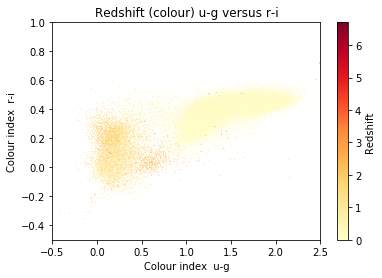

In [50]:
cmap = plt.get_cmap('YlOrRd')

# Define our colour indexes u-g and r-i
u_g = data['u'] - data['g']
r_i = data['r'] - data['i']
# Make a redshift array
redshift = data['redshift']
# Create the plot with plt.scatter and plt.colorbar
plot = plt.scatter(u_g, r_i, s=0.5, lw=0, c=redshift, cmap=cmap)
cb = plt.colorbar(plot)
cb.set_label('Redshift')
# Define your axis labels and plot title
plt.xlabel('Colour index  u-g')
plt.ylabel('Colour index  r-i')
plt.title('Redshift (colour) u-g versus r-i')
# Set any axis limits
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1)

plt.show()

#### Overfitting

Decision trees have many advantages: they are simple to implement, easy to interpret, the data doesn't require too much preparation, and they are reasonably efficient computationally.

Decision trees do have some limitations though, one of the biggest being they tend to over fit the data. What this means is that if they are left unchecked they will create an overly complicated tree that attempts to account for outliers in the data. This comes at the expense of the accuracy of the general trend.

Part of the reason for this over-fitting is that the algorithm works by trying to optimise the decision locally at each node. There are ways in which this can be mitigated. Let us see how constraining the number of decision node rows (the tree depth) impacts the accuracy of our predictions.

In order to see how the tree is overfitting we would like to examine how our decision tree performs for different tree depths. Specifically, we would like to see how it performs on test data compared to the data that was used to train it.

Naïvely we'd expect, the deeper the tree, the better it should perform. However, as the model overfits we see a difference in its accuracy on the training data and the more general testing data.

In [51]:
dtr = DecisionTreeRegressor(max_depth=5)

Depth with lowest median difference : 21


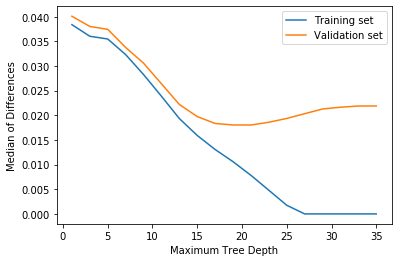

In [53]:
def accuracy_by_treedepth(features, targets, depths):
    # split the data into testing and training sets
    split = features.shape[0]//2

    train_features = features[:split]
    test_features = features[split:]

    train_targets = targets[:split]
    test_targets = targets[split:]
    # initialise arrays or lists to store the accuracies for the below loop
    train_accuracy_arr = []
    test_accuracy_arr = []
    # loop through depths
    for depth in depths:
        # initialize model with the maximum depth. 
        dtr = DecisionTreeRegressor(max_depth=depth)
        # train the model using the training set
        dtr.fit(train_features, train_targets)
        # get the predictions for the training set and calculate their median_diff
        train_predictions = dtr.predict(train_features)
        train_med = median_diff(train_predictions, train_targets)
        train_accuracy_arr.append(train_med)
        # get the predictions for the testing set and calculate their median_diff
        test_predictions = dtr.predict(test_features)
        test_med = median_diff(test_predictions, test_targets)
        test_accuracy_arr.append(test_med)
    # return the accuracies for the training and testing sets
    return train_accuracy_arr, test_accuracy_arr


if __name__ == "__main__":
#     data = np.load('sdss_galaxy_colors.npy')
#     features, targets = get_features_targets(data)

    # Generate several depths to test
    tree_depths = [i for i in range(1, 36, 2)]

    # Call the function
    train_med_diffs, test_med_diffs = accuracy_by_treedepth(features, targets, tree_depths)
    print("Depth with lowest median difference : {}".format(tree_depths[test_med_diffs.index(min(test_med_diffs))]))

    # Plot the results
    train_plot = plt.plot(tree_depths, train_med_diffs, label='Training set')
    test_plot = plt.plot(tree_depths, test_med_diffs, label='Validation set')
    plt.xlabel("Maximum Tree Depth")
    plt.ylabel("Median of Differences")
    plt.legend()
    plt.show()


#### Cross-Validation
The method we used to validate our model so far is known as hold-out validation. Hold out validation splits the data in two, one set to test with and the other to train with. Hold out validation is the most basic form of validation.

While hold-out validation is better than no validation, the measured accuracy (i.e. our median of differences) will vary depending on how we split the data into testing and training subsets. In order to be more certain of our models accuracy we should use k-fold cross validation.

In [56]:
from sklearn.model_selection import KFold

def cross_validate_model(model, features, targets, k):
    kf = KFold(n_splits=k, shuffle=True)
    median_arr = []
    # initialise a list to collect median_diffs for each iteration of the loop below

    for train_indices, test_indices in kf.split(features):
        train_features, test_features = features[train_indices], features[test_indices]
        train_targets, test_targets = targets[train_indices], targets[test_indices]

        # fit the model for the current set
        model.fit(train_features, train_targets)
        # predict using the model
        preds = model.predict(test_features)
        # calculate the median_diff from predicted values and append to results array
        res = median_diff(preds, test_targets)
        median_arr.append(res)
 
    # return the list with your median difference values
    return median_arr

if __name__ == "__main__":
#     data = np.load('./sdss_galaxy_colors.npy')
#     features, targets = get_features_targets(data)

    # initialize model with a maximum depth of 19
    dtr = DecisionTreeRegressor(max_depth=19)

    # call your cross validation function
    diffs = cross_validate_model(dtr, features, targets, 10)

    # Print the values
    print('Differences: {}'.format(', '.join(['{:.3f}'.format(val) for val in diffs])))
    print('Mean difference: {:.3f}'.format(np.mean(diffs)))


Differences: 0.017, 0.017, 0.018, 0.017, 0.017, 0.018, 0.017, 0.018, 0.017, 0.017
Mean difference: 0.017


Median difference: 0.017


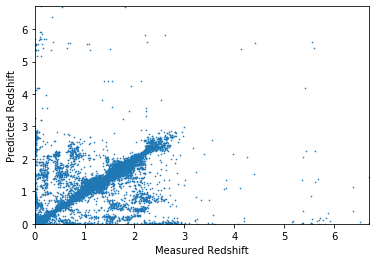

In [57]:
def cross_validate_predictions(model, features, targets, k):
    kf = KFold(n_splits=k, shuffle=True)

    # declare an array for predicted redshifts from each iteration
    all_predictions = np.zeros_like(targets)

    for train_indices, test_indices in kf.split(features):
        # split the data into training and testing
        train_features, test_features = features[train_indices], features[test_indices]
        train_targets, test_targets = targets[train_indices], targets[test_indices]

        # fit the model for the current set
        model.fit(train_features, train_targets)
        # predict using the model
        predictions = model.predict(test_features)
        # put the predicted values in the all_predictions array defined above
        all_predictions[test_indices] = predictions

    # return the predictions
    return all_predictions    


if __name__ == "__main__":
#     data = np.load('./sdss_galaxy_colors.npy')
#     features, targets = get_features_targets(data)

    # initialize model
    dtr = DecisionTreeRegressor(max_depth=19)

    # call your cross validation function
    predictions = cross_validate_predictions(dtr, features, targets, 10)

    # calculate and print the rmsd as a sanity check
    diffs = median_diff(predictions, targets)
    print('Median difference: {:.3f}'.format(diffs))

    # plot the results to see how well our model looks
    plt.scatter(targets, predictions, s=0.4)
    plt.xlim((0, targets.max()))
    plt.ylim((0, predictions.max()))
    plt.xlabel('Measured Redshift')
    plt.ylabel('Predicted Redshift')
    plt.show()

There are several methods and libraries in the sklearn.model_selection modules that provide off the shelf versions of some of the routines that we have just written.

The cross_val_predict function performs the same actions as the cross_validate_predictions function you wrote in the previous question. It can be called with:

In [61]:
from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(dtr, features, targets, cv=10)

# from sklearn.model_selection import cross_val_score
# y_pred = cross_val_predict(dtr, features, targets, cv=10)

#### QSOs:

Our sample of galaxies consists of two different populations: regular galaxies and quasi-stellar objects (QSOs). QSOs are a type of galaxy that contain an Active Galactic Nucleus (AGN): an actively (and intensly) accreting supermassive black hole.

The light emitted from the AGN is significantly brighter than the rest of the galaxy and we are able to detect these QSOs out to much higher redshifts.

Most of the normal galaxies we have been using to create our models have redshifts less than z ≈ 0.4, while the QSOs have redshifts all the way out to z ≈ 6. Due to this contribution from the AGN, the flux magnitudes measured at different wavelengths might not follow the typical profile we assumed when predicting redshifts.

If we train normal galaxies and QSOs separately, we should be able to improve our model.

In [67]:
def split_galaxies_qsos(data):
    # split the data into galaxies and qsos arrays
    galaxies = data[data['spec_class'] == b'GALAXY']
    qsos = data[data['spec_class'] == b'QSO']
    # return the seperated galaxies and qsos arrays
    return galaxies, qsos

def cross_validate_median_diff(data):
    features, targets = get_features_targets(data)
    dtr = DecisionTreeRegressor(max_depth=19)
    return np.mean(cross_validate_model(dtr, features, targets, 10))


if __name__ == "__main__":
#     data = np.load('./sdss_galaxy_colors.npy')

    # Split the data set into galaxies and QSOs
    galaxies, qsos= split_galaxies_qsos(data)

    # Here we cross validate the model and get the cross-validated median difference
    # The cross_validated_med_diff function is in "written_functions"
    galaxy_med_diff = cross_validate_median_diff(galaxies)
    qso_med_diff = cross_validate_median_diff(qsos)

    # Print the results
    print("Median difference for Galaxies: {:.3f}".format(galaxy_med_diff))
    print("Median difference for QSOs: {:.3f}".format(qso_med_diff))

Median difference for Galaxies: 0.016
Median difference for QSOs: 0.076


Our QSOs have a greater median residual (≈ 0.074) than the galaxies (≈ 0.016). There are a couple of possibilities why this is the case.

    1. There are far fewer QSOs (8525) than galaxies (41,475).
    2. Galaxies aren't as bright as QSOs so they become too faint to be detected with SDSS at redshifts ≈ 0.4. This creates a measurement bias.
    
If we take a random sample of galaxies the same size as the QSO data set I get a med_diff of ≈ 0.018 which is slightly higher than the full set, but not enough to account for the gap between the two populations.

The figure below shows the normalised distribution function of the two populations.

![Img](https://imgur.com/Xv7RPGI.jpg)

We can see that the majority of galaxies form a peak around 0.10 while the QSOs are resonably evenly distributed out to redshift  ≈2.5. This can lead to a measurement bias. In the case of the galaxies we have trained our decision tree with target redshifts approximately less than 0.4. As such the predictions from this model will not be larger than the maximum target value. So the maximum difference (or residual) for each galaxy in this set will be a lot smaller than the maximum residual for the QSOs.

We can often get a clearer view of this by looking at the predicted redshifts vs actual redshifts in a plot.

![Img](https://imgur.com/pSLCBJC.jpg)

# Week 6: Classification using Decision Trees

Hubble's book, "The Realm of the Nebulae" (Nebulae back then referred to anything fuzzy: Galaxies come under these), had a number of fascinating insights, not just about astronomy, but also about scientific methodology and the process of classification.

The process of classification involves sorting through the photographs, identifying key features of each galaxy. The more conspicuous examples of each type where then used as what we now call archetypes of each class. And the other galaxies were compared to them in order to classify them.

Hubble used this approach to classify hundreds of galaxies. And in the process, developed one of the most famous classifications schemes in astronomy. The Hubble Sequence or the Hubble tuning fork diagram.

In this scheme, Hubble described the visual properties of galaxies, their morphology or shape, ranging from regular, elliptical, and spiral shaped galaxies, to what appeared to be irregular collections of stars and gas. We later found out that these morphological classifications turn out to be correlated with important physical properties of galaxies. Such as their star formation rate, which helps us understand galaxy formation and evolution.

### Types of Galaxies:

As a first step to understanding how galaxies formed and evolved, astronomers began grouping them together based on similar appearances, forming a Morphological Classification Scheme. The most famous of these is the Hubble tuning fork.
Hubble divided galaxies into elliptical galaxies and spiral galaxies with the intermediate lenticular, or S0 class in between. Elliptical and lenticular galaxies are collectively known as early-type galaxies, because of their simple appearance. Spiral galaxies are known as late-type galaxies, because of their complex structure.

![Img](https://imgur.com/tJvspFT.jpg)

Elliptical galaxies have a smooth, spheroidal appearance with little internal structure. They're dominated by a spheroidal bulge and have no obvious thin disk. Elliptical galaxies are divided into subclasses based on their apparent flattening. E0 galaxies are circular, through to E7 galaxies, which are highly elongated.

On the far right of the diagram, the Sd class of spiral galaxies are essentially the opposite, with a prominent disc and no clear central bulge. Most obviously spiral galaxies all show spiral arms, though, when viewed edge on the arms may not be visible. As we move back along the Hubble tuning fork, we find spiral galaxies with increasingly large bulges, and more tightly wound arms, when seen face on.

The lenticular class have similarities with both spiral and elliptical galaxies. They have a prominent bulge and a prominent disc but no spiral arms. The rectangular looking structure found in the center of many galaxies are called bars. Both lenticular and spiral galaxies are also coming barred and unbarred varieties giving rise to the two prongs of a tuning fork. 

![Img](https://imgur.com/zgzthNI.jpg)

And finally, there is a class of irregular galaxies that don't fit any of the previous described types. These are mainly low mass galaxies that are highly asymmetric with very chaotic structures. Other galaxies that may sometimes be put into this category are merging galaxies where two galaxies are in the process of crashing into one another leading to very dramatic morphologies.

Disks and bulges are thought to form in very different ways and so understanding whether a galaxy is mostly bulge, mostly disk, or a mixture of both is related to how it formed.

Disks consist mostly of stars on circular orbits all in the same plane resulting in the flattened, circular structures we see in spiral galaxies. These disks of stars likely formed in a gentle fashion from a disk of gas over many billions of years.

Bulges consist of stars on random orbits, giving them their spheroidal shapes. Bulges may have been formed by the mergers of two or more galaxies, by internal dynamical processes in disc galaxies, or from the collapse of massive clouds of gas early in the universe.

Spiral and elliptical galaxies don't just differ in their structure, but also in their colors as well. Spiral galaxies are predominantly blue, whereas elliptical and lenticular galaxies are red or yellow.

The color of a galaxy tells us about the average age of stars in that galaxy. Massive stars are very hot and are blue-white in color, but these starts burn their fuel very quickly and die after only a few million years. Low-mass stars which are very long-lived are cooler and much redder. Therefore blue spiral galaxies contain many recently born hot massive stars and are actively forming new stars. In contrast elliptical galaxies contain mainly colder, red, old stars and stopped forming new stars billion of years ago.

As well as stars spiral galaxies contain lots of gas, the fuel for star formation, and dust, a product of star formation. Whereas elliptical galaxies have very little gas and dust, which is consistent with their lack of young stars.

The Hubble tuning fork is the most widely used classification scheme. But it does have some significant limitations. Spiral arms can be hard to identify when a galaxy is seen close to edge on, so based on morphology alone it can be difficult to differentiate spiral and lenticular galaxies. Similarly, when seen close to face on, it can be hard to distinguish a disk from a bulge, making it hard to decide whether a galaxies is elliptical or lenticular.

Astronomers now believe bars to be relatively short-lived structures. There's little physical difference between barred and unbarred galaxies.

Most importantly, the Hubble classification is not physically motivated and the sequence represents a continuum of properties and not an evolutionary or chronological sequence. Astronomical research is helping to improve this scheme, linking it more closely to the physical processes of galaxy formation.

### Feature Engineering
To train a machine-learning classifier, we need to characterize each galaxy by a set of properties, or features. When we did decision tree regression in the last module, we only used the four Sloan colors, this time, we'll use a richer feature set.

But even for an individual expert classifier, it's best practice to try and formulize your intuition, to increase your classification consistency.

There's also an important difference between decision trees for humans, versus computers. A human scheme can have a question such as, is there anything odd, where the volunteer is expected to use their own judgement. However, for a machine learning algorithm, the features and questions need to be quantifiable.

Perhaps the simplest option would just be to use every pixel in the image for every galaxy. So if we had 512x512 pixel images for each of the five Sloan filters, each galaxy would be represented by 1,310,720 features. This approach of using the raw pixels as features has some advantages. 

    1. Firstly, you minimize the possible bias you might introduce through feature selection. 
    2. Secondly it's simpler, you don't have to implement any sophisticated image analysis features, you can just take the pixels as they are. 
   
However, it also has some disadvantages.

    1. The downside to not introducing bias is that you're not taking advantage of your expert knowledge. Using raw pixels doesn't incorporate existing astronomy knowledge about the problem, like the fact that elliptical galaxies tend to be redder in color because they're made up of older stars.
    2. The second disadvantage is computational. Using every pixel in the image means you haven't reduced the dimensionality of the problem, which makes it computationally expensive. You're building a model using over one million possible features. However, modern computing power has made this raw data approach feasible again and highly successful for image classification, especially using neural nets.
    
    
    
Some characteristics we can use are:

    1. Colour of the galaxy (Colour Index), since it's a really important indicator of the age of the stars in each galaxy.
    2. The ellipticity of the galaxy. We can get a rough idea of the shape of the galaxy by fitting an ellipse to its profile and then using the ratio of the semi-major to semi-minor axes to characterize this shape.
    3. The luminosity profile of the galaxy. This is a measure of how the brightness of a galaxy varies as a function of the radius from its center.
    
These features attempt to replicate properties that the human eye identifies when looking at the image of the galaxy. Now remember, that all features have limitations, just like human observations.

It's important to remember that all features have limitations, just like human observations. For example, the ellipticity of a galaxy is dependent on the inclination with respect to our viewing angle. That's okay because each feature only contributes part of the information that the classifier and uses to build this model.

Using the above features, a decision tree was trained which gave a 10 fold CV accuracy of 79.1%.

### Decision Tree Classification
We will limit our dataset to three types of galaxy: spirals, ellipticals and mergers. The galaxy catalogue we are using is a sample of galaxies where at least 20 human classifiers have come to a consensus on the galaxy type. Examples of spiral and elliptical galaxies were selected where there was a unanimous classification. Due to low sample numbers, merger examples were chosen where at least 80% of human classifiers selected the merger class.

The features that we will be using to do our galaxy classification are colour index, adaptive moments, eccentricities and concentrations. These features are provided as part of the SDSS catalogue.

A brief description is given below. Further information how they are calculated can be found [here](http://skyserver.sdss.org/dr7/en/help/docs/algorithm.asp). 

    1. Colour indices are the same colours (u-g, g-r, r-i, and i-z) we used for regression. Studies of galaxy evolution tell us that spiral galaxies have younger star populations and therefore are 'bluer' (brighter at lower wavelengths). Elliptical galaxies have an older star population and are brighter at higher wavelengths ('redder').
    2. Eccentricity approximates the shape of the galaxy by fitting an ellipse to its profile. Eccentricity is the ratio of the two axis (semi-major and semi-minor). The De Vaucouleurs model was used to attain these two axis. To simplify our experiments, we will use the median eccentricity across the 5 filters.
    3. Adaptive moments also describe the shape of a galaxy. They are used in image analysis to detect similar objects at different sizes and orientations. We use the fourth moment here for each band.
    4. Concentration is similar to the luminosity profile of the galaxy, which measures what proportion of a galaxy's total light is emitted within what radius. A simplified way to represent this is to take the ratio of the radii containing 50% and 90% of the Petrosian flux.

The Petrosian method allows us to compare the radial profiles of galaxies at different distances. The need for Petrosian approach has been described in detail [here](http://spiff.rit.edu/classes/phys443/lectures/gal_1/petro/petro.html).

For these experiments, we will define concentration as: $ \text{conc} = \frac{\text{petro}_{R50}}{\text{petro}_{R90}} $

We will use the concentration from just the u, r and z bands.

The data of the SDSS and Galaxy Zoo for 780 galaxies is available as a NumPy binary file.

In [4]:
import numpy as np
import pandas as pd
data = np.load(r'Week 6/galaxy_catalogue.npy')

In [8]:
df = pd.DataFrame(data)
df.head()

,u-g,g-r,r-i,i-z,ecc,m4_u,m4_g,m4_r,m4_i,m4_z,petroR50_u,petroR50_r,petroR50_z,petroR90_u,petroR90_r,petroR90_z,class
0,1.85765,0.67158,0.42310,0.30610,0.585428,2.251946,2.339849,2.380652,2.359738,2.395528,3.095123,3.818919,3.826230,5.174814,8.263009,11.477340,merger
1,1.74259,0.86085,0.44927,0.28851,0.749812,2.031566,2.084156,2.092272,2.124075,2.133154,1.430436,1.422533,1.385727,3.732712,3.416921,3.330347,merger
2,2.10697,0.96710,0.56810,0.33747,0.630089,1.992887,2.450746,2.473116,2.465324,2.438683,3.099957,3.623704,3.463300,9.110857,8.354343,11.265390,merger
3,1.22840,0.60446,0.39049,0.28913,0.668999,2.056115,2.182252,2.309510,2.391414,2.472397,3.627267,4.063471,3.717708,9.580675,12.202420,11.826220,merger
4,1.80792,0.78124,0.45528,0.35067,0.500170,2.259167,2.194723,2.264567,2.334713,2.352568,3.256751,3.153533,2.254511,9.206746,9.790146,6.636931,merger


In [10]:
labels = df["class"]
df = df.drop("class",1)

In [15]:
df["conc_u"] = df['petroR50_u']/df['petroR90_u']
df["conc_r"] = df['petroR50_r']/df['petroR90_r']
df["conc_z"] = df['petroR50_z']/df['petroR90_z']

df = df.drop(["petroR50_u","petroR50_r","petroR50_z","petroR90_u","petroR90_r","petroR90_z"],1)

In [19]:
X = df.values
y = labels

In [28]:
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
preds = cross_val_predict(dtc, X, y, cv=10)

In [31]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true = y, y_pred = preds)
print(f"Accuracy = {acc}")

Accuracy = 0.791025641025641


In [39]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')

Confusion matrix, without normalization
[[235   4  21]
 [  5 199  56]
 [ 24  53 183]]


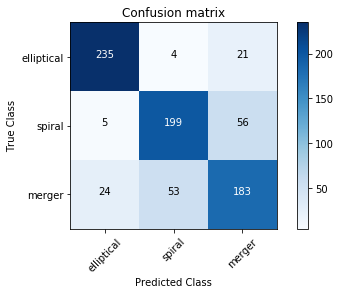

In [42]:
from sklearn.metrics import confusion_matrix
class_labels = list(set(y))
model_cm = confusion_matrix(y_true=y, y_pred=preds, labels=class_labels)

plt.figure()
plot_confusion_matrix(model_cm, classes=class_labels, normalize=False)
plt.show()


### Ensemble Learning
This 'noise' could either be from the Galaxy Zoo volunteer classifications or it could be from the features derived from physical observations. To construct a classifier that's robust to noisy data from base classifiers that are likely to overfit their noise, we will use ensemble learning.

In ensemble learning, multiple models are trained and their results are combined together in some way. For classification, this typically includes voting and for aggression, it typically involves taking the mean of each ensembled learner.

The idea behind ensemble learning is, that the combined classifications of multiple weak learners can give a more reliable, robust result, in the face of imperfect training data, and any non-determinism in the training process. For ensembles to work better than individual classifiers, the members of the ensemble must be different in some way; they must give independent results. If they all gave the same predictions on each instance, then having more of them would make no difference at all.

There are many ways to achieve this model independence, including using different machine learning algorithms, different parameters, for example the tree depth, or different training data. One of the most popular methods is called bootstrap aggregating, or bagging for short.

In bagging, samples of the training data are bootstrapped, i.e, selected with replacement from the original training set. The models are trained on each sample. Bagging makes each training set different with an emphasis on different training instances. A random forest classifier is a supervised machine learning algorithm that uses an ensemble of decision tree classifiers. It builds an ensemble by randomly selecting, either subsets of training instances, bagging, or selecting a subset of features of each decision point.

#### Random Forests

A random forest is a collection of decision trees that have each been independently trained using different subsets of the training data and/or different combinations of features in those subsets.

When making a prediction, every tree in the forest gives its own prediction and the most common classification is taken as the overall forest prediction (in regression the mean prediction is used). Random forests help to mitigate overfitting in decision trees.

    1. (Bagging) Training data is spread across decision trees. The subsets are created by taking random samples with replacement. This means that a given data point can be used in several subsets. (This is different from the subsets used in cross validation where each data point belongs to one subset).

    2. (Feature Selection) Individual trees are trained with different subsets of features. So in our current problem, one tree might be trained using eccentricity and another using concentration and the 4th adaptive moment. By using different combinations of input features you create expert trees that are can better identify classes by a given feature.

Python's sklearn random forest only uses the first form of sampling, bagging, but R's uses feature selection. We have a number of extra parameters to consider setting but the most important is the number of decision trees that the random forest builds. A larger number will use more samples from the original data and be more robust to noise and overfitting.

In [43]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=50)
preds = cross_val_predict(rfc, X, y, cv=10)

In [44]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true = y, y_pred = preds)
print(f"Accuracy = {acc}")

Accuracy = 0.867948717948718


Confusion matrix, without normalization
[[246   1  13]
 [  2 218  40]
 [ 15  32 213]]


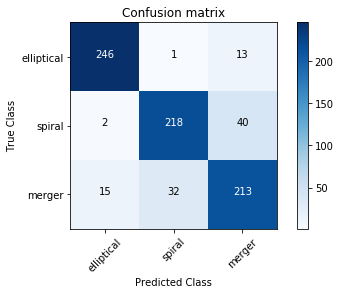

In [45]:
from sklearn.metrics import confusion_matrix
class_labels = list(set(y))
model_cm = confusion_matrix(y_true=y, y_pred=preds, labels=class_labels)

plt.figure()
plot_confusion_matrix(model_cm, classes=class_labels, normalize=False)
plt.show()
